# SAT on Long-Tailed CIFAR-10: Balanced and Worst-Group Analysis

This notebook evaluates Self-Adaptive Training on imbalanced CIFAR-10 with:
- **Balanced Error Rate**: Average error across all classes (unweighted)
- **Worst-Group Error Rate**: Error of the worst-performing class
- **AURC (Balanced)**: Area Under Risk-Coverage curve using balanced error
- **AURC (Worst-Group)**: Area Under Risk-Coverage curve using worst-group error

**Settings:**
- Architecture: VGG-16 with Batch Normalization
- Dataset: CIFAR-10 Long-Tailed (Imbalance Ratio configurable)
- Loss: SAT with momentum 0.99
- Training: 300 epochs

## 1. Setup and Imports

In [ ]:
import os
import time
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from PIL import Image

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device:", torch.cuda.get_device_name(0))

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# ============================================================================
# EMBEDDED UTILITY CLASSES (No external imports needed)
# ============================================================================

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


class SelfAdaptiveTraining():
    """Self-Adaptive Training loss function"""
    def __init__(self, num_examples=50000, num_classes=10, mom=0.9):
        self.prob_history = torch.zeros(num_examples, num_classes)
        self.updated = torch.zeros(num_examples, dtype=torch.int)
        self.mom = mom
        self.num_classes = num_classes

    def _update_prob(self, prob, index, y):
        onehot = torch.zeros_like(prob)
        onehot[torch.arange(y.shape[0]), y] = 1
        prob_history = self.prob_history[index].clone().to(prob.device)

        # if not inited, use onehot label to initialize running vector
        cond = (self.updated[index] == 1).to(prob.device).unsqueeze(-1).expand_as(prob)
        prob_mom = torch.where(cond, prob_history, onehot)

        # momentum update
        prob_mom = self.mom * prob_mom + (1 - self.mom) * prob

        self.updated[index] = 1
        self.prob_history[index] = prob_mom.to(self.prob_history.device)

        return prob_mom

    def __call__(self, logits, y, index):
        prob = F.softmax(logits.detach()[:, :self.num_classes], dim=1)
        prob = self._update_prob(prob, index, y)

        soft_label = torch.zeros_like(logits)
        soft_label[torch.arange(y.shape[0]), y] = prob[torch.arange(y.shape[0]), y]
        soft_label[:, -1] = 1 - prob[torch.arange(y.shape[0]), y]
        soft_label = F.normalize(soft_label, dim=1, p=1)
        loss = torch.sum(-F.log_softmax(logits, dim=1) * soft_label, dim=1)
        return torch.mean(loss)


# ============================================================================
# VGG-16 MODEL (Embedded)
# ============================================================================

class VGG(nn.Module):
    def __init__(self, features, num_classes=1000, input_size=32):
        super(VGG, self).__init__()
        self.features = features
        if input_size == 32:
            self.classifier = nn.Sequential(
                nn.Linear(512, 512), nn.ReLU(inplace=True),
                nn.BatchNorm1d(512), nn.Dropout2d(0.5),
                nn.Linear(512, num_classes)
            )
        elif input_size == 64:
            self.classifier = nn.Sequential(
                nn.Linear(2048, 512), nn.ReLU(inplace=True),
                nn.BatchNorm1d(512), nn.Dropout2d(0.5),
                nn.Linear(512, num_classes)
            )
        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif type(v) == int:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.ReLU(inplace=True), nn.BatchNorm2d(v)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
        elif type(v) == float:
            layers += [nn.Dropout2d(v)]
    return nn.Sequential(*layers)


cfg_vgg16 = {
    'D': [64, 0.3, 64, 'M', 128, 0.4, 128, 'M', 256, 0.4, 256, 0.4, 256, 'M',
          512, 0.4, 512, 0.4, 512, 'M', 512, 0.4, 512, 0.4, 512, 'M', 0.5]
}


def vgg16_bn(num_classes=1000, input_size=32, **kwargs):
    """VGG 16-layer model with batch normalization"""
    model = VGG(make_layers(cfg_vgg16['D'], batch_norm=True), 
                num_classes=num_classes, input_size=input_size, **kwargs)
    return model


print("✅ All utility classes and VGG-16 model embedded successfully!")
print("🎯 100% self-contained - no external files needed!")

PyTorch version: 2.9.1+cu128
CUDA available: True
CUDA device: NVIDIA GeForce RTX 4060 Laptop GPU


## 2. Long-Tailed Dataset Loading with HuggingFace Datasets

In [38]:
# Wrapper for CIFAR-10-LT to work with PyTorch DataLoader
class CIFAR10LTWrapper(torch.utils.data.Dataset):
    """Wrapper for HuggingFace CIFAR-10-LT dataset"""
    
    def __init__(self, hf_dataset, transform=None):
        """
        Args:
            hf_dataset: HuggingFace dataset object
            transform: torchvision transforms to apply
        """
        self.dataset = hf_dataset
        self.transform = transform
        self.targets = np.array([item['label'] for item in hf_dataset])
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        item = self.dataset[index]
        img = item['img']
        target = item['label']
        
        # Convert to PIL Image if needed
        if not isinstance(img, Image.Image):
            img = Image.fromarray(np.array(img))
        
        if self.transform is not None:
            img = self.transform(img)
        
        return img, target, index
    
    def get_class_distribution(self):
        """Return distribution of samples per class"""
        unique, counts = np.unique(self.targets, return_counts=True)
        return dict(zip(unique, counts))

print("CIFAR-10-LT wrapper class defined.")

CIFAR-10-LT wrapper class defined.


## 3. Configuration

In [39]:
# Configuration
class Config:
    # Dataset settings
    dataset = 'cifar10'
    dataset_name = 'r-100'  # HuggingFace dataset name: r-10, r-20, r-50, r-100, r-200
    imbalance_ratio = 100  # Majority/minority class ratio (10, 20, 50, 100, 200)
    
    # Architecture
    arch = 'vgg16_bn'
    
    # Training settings
    loss_type = 'sat'
    epochs = 300
    pretrain_epochs = 0
    
    # Hyperparameters (same as balanced SAT)
    batch_size_train = 128
    batch_size_test = 200
    lr = 0.1
    momentum = 0.9
    sat_momentum = 0.99
    weight_decay = 5e-4
    gamma = 0.5
    schedule = [25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275]
    
    # Evaluation settings
    expected_coverage = [100., 99., 98., 97., 95., 90., 85., 80., 75., 70., 60., 50., 40., 30., 20., 10.]
    
    # System settings
    gpu_id = '0'
    num_workers = 4
    manual_seed = 42
    save_dir = f'./checkpoints/sat_longtailed_ir{100}'
    
config = Config()

# Set random seeds
random.seed(config.manual_seed)
torch.manual_seed(config.manual_seed)
np.random.seed(config.manual_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(config.manual_seed)

# Set GPU
os.environ['CUDA_VISIBLE_DEVICES'] = config.gpu_id
use_cuda = torch.cuda.is_available()

# Create save directory
os.makedirs(config.save_dir, exist_ok=True)

print(f"Configuration:")
print(f"  Dataset: Long-Tailed CIFAR-10 (dataset_name={config.dataset_name}, IR={config.imbalance_ratio})")
print(f"  Architecture: {config.arch}")
print(f"  Loss: {config.loss_type}")
print(f"  Epochs: {config.epochs}")
print(f"  SAT Momentum: {config.sat_momentum}")
print(f"  Save directory: {config.save_dir}")

Configuration:
  Dataset: Long-Tailed CIFAR-10 (dataset_name=r-100, IR=100)
  Architecture: vgg16_bn
  Loss: sat
  Epochs: 300
  SAT Momentum: 0.99
  Save directory: ./checkpoints/sat_longtailed_ir100


## 4. Dataset Preparation

Repo card metadata block was not found. Setting CardData to empty.
Repo card metadata block was not found. Setting CardData to empty.
Repo card metadata block was not found. Setting CardData to empty.


Preparing Long-Tailed CIFAR-10 from HuggingFace (dataset=r-100)...
Loading dataset from cifar10-lt.py script...

Training samples: 2478
Test samples: 10000
Number of classes: 10

Training samples: 2478
Test samples: 10000
Number of classes: 10


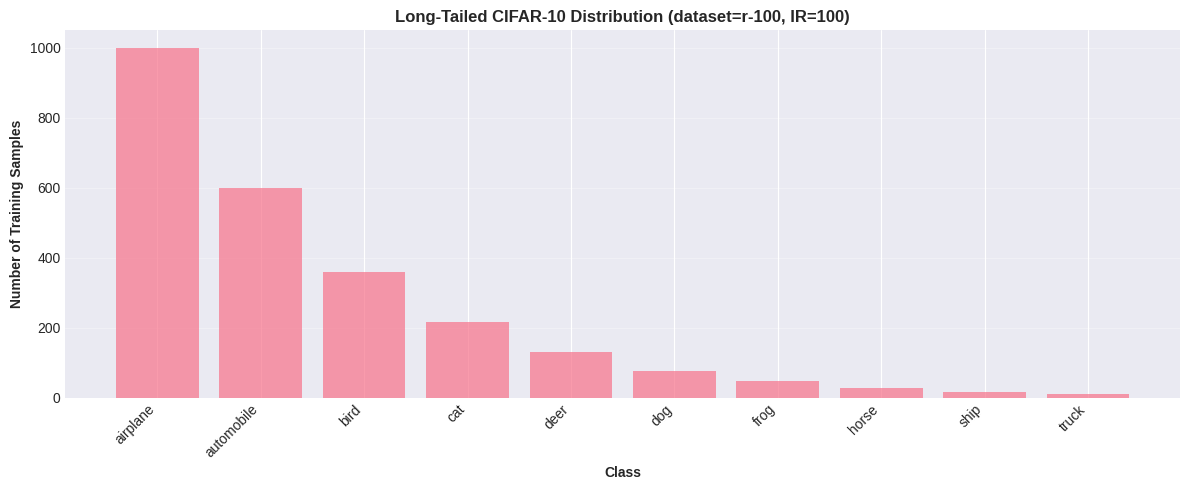


Class distribution saved to ./checkpoints/sat_longtailed_ir100/dataset_distribution.png


In [ ]:
# ============================================================================
# CIFAR-10 Long-Tailed Dataset Preparation (100% Self-Contained)
# ============================================================================

import torchvision.datasets as tv_datasets

print(f'Creating Long-Tailed CIFAR-10 programmatically (IR={config.imbalance_ratio})...')

num_classes = 10
input_size = 32

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Download standard CIFAR-10
print("Downloading CIFAR-10 dataset...")
base_trainset = tv_datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
base_testset = tv_datasets.CIFAR10(root='./data', train=False, download=True, transform=None)

# Group indices by class
class_indices_train = defaultdict(list)
for idx in range(len(base_trainset)):
    _, label = base_trainset[idx]
    class_indices_train[label].append(idx)

# Create imbalanced distribution using exponential decay
print(f"Creating exponential imbalance with ratio 1:{config.imbalance_ratio}...")
selected_train_indices = []
samples_per_class = []

img_max = 5000  # Original samples per class in CIFAR-10
imb_factor = 1.0 / config.imbalance_ratio

for cls_idx in range(num_classes):
    # Exponential decay formula
    n_samples = int(img_max * (imb_factor ** (cls_idx / (num_classes - 1.0))))
    n_samples = max(1, min(n_samples, len(class_indices_train[cls_idx])))
    
    # Randomly select subset
    np.random.seed(config.manual_seed + cls_idx)  # Reproducible
    selected = np.random.choice(class_indices_train[cls_idx], size=n_samples, replace=False)
    selected_train_indices.extend(selected.tolist())
    samples_per_class.append(n_samples)
    
print(f"Samples per class: {samples_per_class}")

# Create imbalanced training subset
class ImbalancedSubset(Subset):
    """Subset that returns (img, label, index)"""
    def __getitem__(self, idx):
        img, target = self.dataset[self.indices[idx]]
        return img, target, idx

trainset_subset = ImbalancedSubset(base_trainset, selected_train_indices)

# Test set remains balanced (all samples)
testset_subset = ImbalancedSubset(base_testset, list(range(len(base_testset))))

# Wrapper to apply transforms
class TransformWrapper(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        # Extract targets for get_class_distribution
        self.targets = []
        for idx in range(len(subset)):
            _, target, _ = subset[idx]
            self.targets.append(target)
        self.targets = np.array(self.targets)
    
    def __len__(self):
        return len(self.subset)
    
    def __getitem__(self, idx):
        img, target, original_idx = self.subset[idx]
        if self.transform:
            img = self.transform(img)
        return img, target, idx
    
    def get_class_distribution(self):
        unique, counts = np.unique(self.targets, return_counts=True)
        return dict(zip(unique, counts))

# Apply transforms
trainset = TransformWrapper(trainset_subset, transform=transform_train)
testset = TransformWrapper(testset_subset, transform=transform_test)

# Create data loaders
trainloader = DataLoader(trainset, batch_size=config.batch_size_train, 
                        shuffle=True, num_workers=config.num_workers)
testloader = DataLoader(testset, batch_size=config.batch_size_test, 
                       shuffle=False, num_workers=config.num_workers)

print(f"\n✅ Dataset created successfully!")
print(f"Training samples: {len(trainset)} (imbalanced)")
print(f"Test samples: {len(testset)} (balanced)")
print(f"Number of classes: {num_classes}")

# Visualize distribution
train_dist = trainset.get_class_distribution()
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(range(num_classes), [train_dist[i] for i in range(num_classes)], alpha=0.7, color='steelblue', edgecolor='black')
ax.set_xlabel('Class', fontweight='bold', fontsize=12)
ax.set_ylabel('Number of Training Samples', fontweight='bold', fontsize=12)
ax.set_title(f'Long-Tailed CIFAR-10 Distribution (IR={config.imbalance_ratio})', fontweight='bold', fontsize=14)
ax.set_xticks(range(num_classes))
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.grid(True, alpha=0.3, axis='y')

# Add count labels on bars
for i, count in enumerate(samples_per_class):
    ax.text(i, count + 50, str(count), ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(config.save_dir, 'dataset_distribution.png'), dpi=150)
plt.show()

print(f"\n📊 Class distribution saved to {config.save_dir}/dataset_distribution.png")
print(f"\n🎯 No external files needed - 100% self-contained!")

## 5. Model Setup

In [ ]:
# Create model
print(f"Creating model: {config.arch}")

model_num_classes = num_classes + 1  # Extra dimension for abstention
model = vgg16_bn(num_classes=model_num_classes, input_size=input_size)

if use_cuda:
    model = torch.nn.DataParallel(model.cuda())
    cudnn.benchmark = True

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params/1e6:.2f}M")

# Setup loss function
criterion = SelfAdaptiveTraining(num_examples=len(trainset), num_classes=num_classes, mom=config.sat_momentum)

# Setup optimizer
optimizer = optim.SGD(model.parameters(), lr=config.lr, momentum=config.momentum, weight_decay=config.weight_decay)

print(f"Loss function: {config.loss_type}")
print(f"Optimizer: SGD (lr={config.lr}, momentum={config.momentum}, weight_decay={config.weight_decay})")

Creating model: vgg16_bn
Total parameters: 14.99M
Loss function: sat
Optimizer: SGD (lr=0.1, momentum=0.9, weight_decay=0.0005)
Total parameters: 14.99M
Loss function: sat
Optimizer: SGD (lr=0.1, momentum=0.9, weight_decay=0.0005)


## 6. Training Functions with Group-Aware Metrics

In [42]:
def train_epoch(trainloader, model, criterion, optimizer, epoch, use_cuda, config):
    """Train for one epoch"""
    model.train()
    
    losses = AverageMeter()
    top1 = AverageMeter()
    
    # Track per-class accuracy
    class_correct = np.zeros(num_classes)
    class_total = np.zeros(num_classes)
    
    for batch_idx, batch_data in enumerate(trainloader):
        inputs, targets, indices = batch_data
        
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate loss
        if epoch >= config.pretrain_epochs:
            loss = criterion(outputs, targets, indices)
        else:
            loss = F.cross_entropy(outputs[:, :-1], targets)
        
        # Measure accuracy
        prec1 = accuracy(outputs.data, targets.data, topk=(1,))[0]
        losses.update(loss.item(), inputs.size(0))
        top1.update(prec1.item(), inputs.size(0))
        
        # Per-class statistics
        _, predicted = outputs[:, :-1].max(1)
        for i in range(num_classes):
            mask = targets == i
            if mask.sum() > 0:
                class_correct[i] += (predicted[mask] == targets[mask]).sum().item()
                class_total[i] += mask.sum().item()
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Calculate balanced accuracy
    class_acc = []
    for i in range(num_classes):
        if class_total[i] > 0:
            class_acc.append(100.0 * class_correct[i] / class_total[i])
        else:
            class_acc.append(0.0)
    
    balanced_acc = np.mean(class_acc)
    worst_acc = np.min(class_acc)
    
    return losses.avg, top1.avg, balanced_acc, worst_acc

def test_epoch(testloader, model, criterion, epoch, use_cuda, config):
    """Test for one epoch with group-aware metrics"""
    model.eval()
    
    losses = AverageMeter()
    top1 = AverageMeter()
    
    # Track per-class statistics
    class_correct = np.zeros(num_classes)
    class_total = np.zeros(num_classes)
    
    # Store predictions for coverage analysis
    all_reservations = []
    all_predictions = []
    all_targets = []
    all_correct = []
    
    with torch.no_grad():
        for batch_idx, batch_data in enumerate(testloader):
            inputs, targets, indices = batch_data
            
            if use_cuda:
                inputs = inputs.cuda()
            
            outputs = model(inputs).cpu()
            
            # Calculate loss
            if epoch >= config.pretrain_epochs:
                loss = F.cross_entropy(outputs[:, :-1], targets)
                
                # Get reservation scores
                outputs_soft = F.softmax(outputs, dim=1)
                class_probs = outputs_soft[:, :-1]
                reservation = outputs_soft[:, -1]
                
                _, predictions = class_probs.max(1)
            else:
                loss = F.cross_entropy(outputs[:, :-1], targets)
                _, predictions = outputs[:, :-1].max(1)
                reservation = torch.zeros(len(targets))
            
            # Overall accuracy
            prec1 = accuracy(outputs[:, :-1].data, targets.data, topk=(1,))[0]
            losses.update(loss.item(), inputs.size(0))
            top1.update(prec1.item(), inputs.size(0))
            
            # Per-class statistics
            correct = predictions == targets
            for i in range(num_classes):
                mask = targets == i
                if mask.sum() > 0:
                    class_correct[i] += correct[mask].sum().item()
                    class_total[i] += mask.sum().item()
            
            # Store for coverage analysis
            all_reservations.extend(reservation.numpy().tolist())
            all_predictions.extend(predictions.numpy().tolist())
            all_targets.extend(targets.numpy().tolist())
            all_correct.extend(correct.numpy().tolist())
    
    # Calculate balanced and worst-group accuracy
    class_acc = []
    for i in range(num_classes):
        if class_total[i] > 0:
            class_acc.append(100.0 * class_correct[i] / class_total[i])
        else:
            class_acc.append(0.0)
    
    balanced_acc = np.mean(class_acc)
    worst_acc = np.min(class_acc)
    
    # Calculate coverage-based metrics
    coverage_results = calculate_group_coverage_metrics(
        np.array(all_reservations),
        np.array(all_predictions),
        np.array(all_targets),
        np.array(all_correct),
        config.expected_coverage
    )
    
    return losses.avg, top1.avg, balanced_acc, worst_acc, class_acc, coverage_results

def calculate_group_coverage_metrics(reservations, predictions, targets, correct, coverages):
    """Calculate balanced and worst-group error at different coverage levels"""
    results = []
    
    # Sort by reservation (high to low - high reservation = less confident = more likely to abstain)
    sorted_indices = np.argsort(reservations)[::-1]
    sorted_correct = correct[sorted_indices]
    sorted_targets = targets[sorted_indices]
    
    for coverage in coverages:
        # Select samples based on coverage (exclude high reservation samples)
        n_samples = int(len(reservations) * coverage / 100)
        if n_samples == 0:
            continue
        
        # Take samples starting from lowest reservation (most confident)
        selected_correct = sorted_correct[-n_samples:]
        selected_targets = sorted_targets[-n_samples:]
        
        # Calculate per-class error
        class_errors = []
        for cls in range(num_classes):
            mask = selected_targets == cls
            if mask.sum() > 0:
                cls_error = 100.0 * (1 - selected_correct[mask].mean())
                class_errors.append(cls_error)
            else:
                class_errors.append(0.0)  # No samples for this class at this coverage
        
        balanced_error = np.mean(class_errors)
        worst_error = np.max(class_errors)
        overall_error = 100.0 * (1 - selected_correct.mean())
        
        results.append({
            'coverage': coverage,
            'overall_error': overall_error,
            'balanced_error': balanced_error,
            'worst_group_error': worst_error,
            'class_errors': class_errors
        })
    
    return results

print("Training and evaluation functions defined.")

Training and evaluation functions defined.


## 7. Training Loop

In [43]:
# Training history
history = {
    'epoch': [],
    'train_loss': [],
    'train_acc': [],
    'train_balanced_acc': [],
    'train_worst_acc': [],
    'test_loss': [],
    'test_acc': [],
    'test_balanced_acc': [],
    'test_worst_acc': [],
    'test_class_acc': [],
    'coverage_results': []
}

print(f"Starting training for {config.epochs} epochs...")
print("=" * 100)
print(f"{'Epoch':>5} | {'LR':>10} | {'Train Acc':>10} | {'Bal Acc':>10} | {'Worst Acc':>10} | {'Test Acc':>10} | {'Bal Acc':>10} | {'Worst Acc':>10} | {'Time':>6} | {'Status'}")
print("=" * 100)

best_balanced_acc = 0.0
best_worst_acc = 0.0
start_time = time.time()

for epoch in range(config.epochs):
    epoch_start = time.time()
    
    # Adjust learning rate
    if epoch in config.schedule:
        config.lr *= config.gamma
        for param_group in optimizer.param_groups:
            param_group['lr'] = config.lr
    
    # Train
    train_loss, train_acc, train_bal_acc, train_worst_acc = train_epoch(
        trainloader, model, criterion, optimizer, epoch, use_cuda, config
    )
    
    # Test
    test_loss, test_acc, test_bal_acc, test_worst_acc, test_class_acc, coverage_results = test_epoch(
        testloader, model, criterion, epoch, use_cuda, config
    )
    
    # Save history
    history['epoch'].append(epoch + 1)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_balanced_acc'].append(train_bal_acc)
    history['train_worst_acc'].append(train_worst_acc)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)
    history['test_balanced_acc'].append(test_bal_acc)
    history['test_worst_acc'].append(test_worst_acc)
    history['test_class_acc'].append(test_class_acc)
    history['coverage_results'].append(coverage_results)
    
    epoch_time = time.time() - epoch_start
    
    # Track best models
    status = ""
    if test_bal_acc > best_balanced_acc:
        best_balanced_acc = test_bal_acc
        checkpoint_path = os.path.join(config.save_dir, 'best_balanced_model.pth')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'balanced_acc': best_balanced_acc,
        }, checkpoint_path)
        status += "*BAL* "
    
    if test_worst_acc > best_worst_acc:
        best_worst_acc = test_worst_acc
        checkpoint_path = os.path.join(config.save_dir, 'best_worst_model.pth')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'worst_acc': best_worst_acc,
        }, checkpoint_path)
        status += "*WORST*"
    
    # Compact output
    print(f"{epoch+1:5d} | {config.lr:10.6f} | {train_acc:9.2f}% | {train_bal_acc:9.2f}% | {train_worst_acc:9.2f}% | "
          f"{test_acc:9.2f}% | {test_bal_acc:9.2f}% | {test_worst_acc:9.2f}% | {epoch_time:5.1f}s | {status}")
    
    # Save periodic checkpoint
    if (epoch + 1) % 50 == 0 or (epoch + 1) == config.epochs:
        checkpoint_path = os.path.join(config.save_dir, f'checkpoint_epoch_{epoch+1}.pth')
        torch.save(model, checkpoint_path)

total_time = time.time() - start_time
print("\n" + "=" * 100)
print(f"Training completed in {total_time/3600:.2f} hours")
print(f"Best balanced accuracy: {best_balanced_acc:.2f}%")
print(f"Best worst-group accuracy: {best_worst_acc:.2f}%")
print("=" * 100)

Starting training for 300 epochs...
Epoch |         LR |  Train Acc |    Bal Acc |  Worst Acc |   Test Acc |    Bal Acc |  Worst Acc |   Time | Status


/home/viet2005/workspace/Research/ltr_xai/SAT-Ensemble/venv/lib/python3.12/site-packages/torch/nn/functional.py:1531: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


    1 |   0.100000 |     26.88% |     11.10% |      0.00% |     10.00% |     10.00% |      0.00% |   2.4s | *BAL* 
    2 |   0.100000 |     34.50% |     11.81% |      0.00% |     17.50% |     17.50% |      0.00% |   2.3s | *BAL* 
    2 |   0.100000 |     34.50% |     11.81% |      0.00% |     17.50% |     17.50% |      0.00% |   2.3s | *BAL* 
    3 |   0.100000 |     37.97% |     14.30% |      0.00% |     16.74% |     16.74% |      0.00% |   2.3s | 
    3 |   0.100000 |     37.97% |     14.30% |      0.00% |     16.74% |     16.74% |      0.00% |   2.3s | 
    4 |   0.100000 |     38.46% |     12.81% |      0.00% |     17.68% |     17.68% |      0.00% |   2.3s | *BAL* 
    4 |   0.100000 |     38.46% |     12.81% |      0.00% |     17.68% |     17.68% |      0.00% |   2.3s | *BAL* 
    5 |   0.100000 |     38.94% |     13.05% |      0.00% |     14.44% |     14.44% |      0.00% |   2.4s | 
    5 |   0.100000 |     38.94% |     13.05% |      0.00% |     14.44% |     14.44% |      0.00% |

## 8. Visualization: Training Dynamics

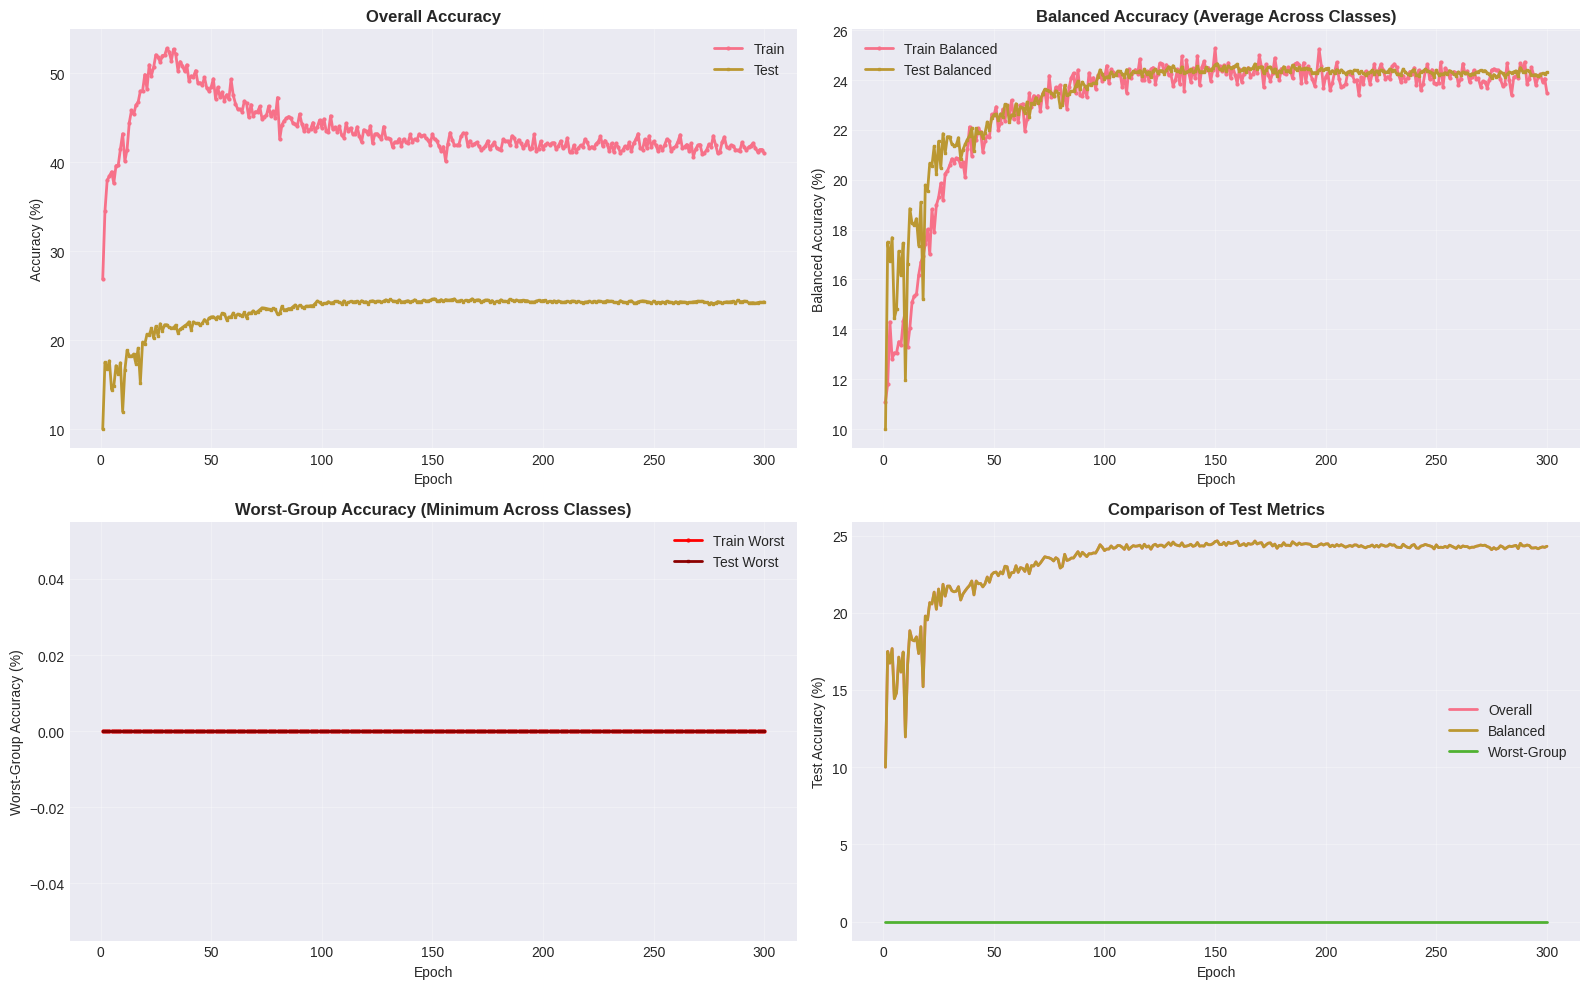

Training curves saved to ./checkpoints/sat_longtailed_ir100/training_curves.png


In [44]:
# Training curves
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Overall accuracy
ax = axes[0, 0]
ax.plot(history['epoch'], history['train_acc'], label='Train', linewidth=2, marker='o', markersize=2)
ax.plot(history['epoch'], history['test_acc'], label='Test', linewidth=2, marker='s', markersize=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Overall Accuracy', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Balanced accuracy
ax = axes[0, 1]
ax.plot(history['epoch'], history['train_balanced_acc'], label='Train Balanced', linewidth=2, marker='o', markersize=2)
ax.plot(history['epoch'], history['test_balanced_acc'], label='Test Balanced', linewidth=2, marker='s', markersize=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Balanced Accuracy (%)')
ax.set_title('Balanced Accuracy (Average Across Classes)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Worst-group accuracy
ax = axes[1, 0]
ax.plot(history['epoch'], history['train_worst_acc'], label='Train Worst', linewidth=2, marker='o', markersize=2, color='red')
ax.plot(history['epoch'], history['test_worst_acc'], label='Test Worst', linewidth=2, marker='s', markersize=2, color='darkred')
ax.set_xlabel('Epoch')
ax.set_ylabel('Worst-Group Accuracy (%)')
ax.set_title('Worst-Group Accuracy (Minimum Across Classes)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. All metrics together
ax = axes[1, 1]
ax.plot(history['epoch'], history['test_acc'], label='Overall', linewidth=2)
ax.plot(history['epoch'], history['test_balanced_acc'], label='Balanced', linewidth=2)
ax.plot(history['epoch'], history['test_worst_acc'], label='Worst-Group', linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Test Accuracy (%)')
ax.set_title('Comparison of Test Metrics', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(config.save_dir, 'training_curves.png'), dpi=150)
plt.show()

print(f"Training curves saved to {config.save_dir}/training_curves.png")

## 9. Per-Class Performance Analysis


Final Per-Class Performance:


,Class,Train Samples,Test Accuracy (%),Test Error (%)
0,airplane,1000,89.3,10.7
1,automobile,599,72.4,27.6
2,bird,359,67.5,32.5
3,cat,215,13.9,86.1
4,deer,129,0.0,100.0
5,dog,77,0.0,100.0
6,frog,46,0.0,100.0
7,horse,27,0.0,100.0
8,ship,16,0.0,100.0
9,truck,10,0.0,100.0


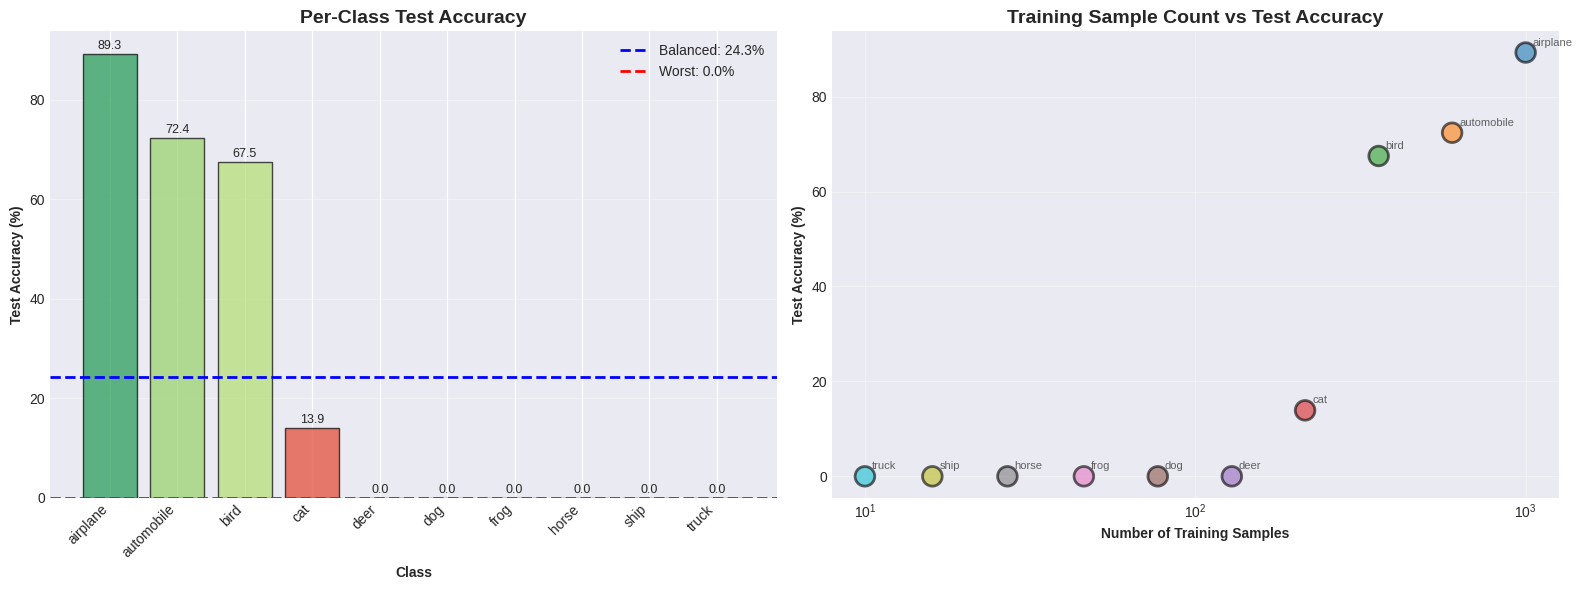


Per-class analysis saved to ./checkpoints/sat_longtailed_ir100/per_class_performance.png


In [45]:
# Analyze final per-class performance
final_class_acc = history['test_class_acc'][-1]
train_dist = trainset.get_class_distribution()

# Create DataFrame
df_class_perf = pd.DataFrame({
    'Class': class_names,
    'Train Samples': [train_dist[i] for i in range(num_classes)],
    'Test Accuracy (%)': final_class_acc,
    'Test Error (%)': [100 - acc for acc in final_class_acc]
})

print("\nFinal Per-Class Performance:")
display(df_class_perf)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Accuracy by class
ax = axes[0]
colors = plt.cm.RdYlGn(np.array(final_class_acc) / 100)
bars = ax.bar(range(num_classes), final_class_acc, color=colors, alpha=0.7, edgecolor='black')
ax.set_xlabel('Class', fontweight='bold')
ax.set_ylabel('Test Accuracy (%)', fontweight='bold')
ax.set_title('Per-Class Test Accuracy', fontweight='bold', fontsize=14)
ax.set_xticks(range(num_classes))
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.axhline(y=np.mean(final_class_acc), color='blue', linestyle='--', linewidth=2, label=f'Balanced: {np.mean(final_class_acc):.1f}%')
ax.axhline(y=np.min(final_class_acc), color='red', linestyle='--', linewidth=2, label=f'Worst: {np.min(final_class_acc):.1f}%')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, acc in enumerate(final_class_acc):
    ax.text(i, acc + 1, f'{acc:.1f}', ha='center', fontsize=9)

# 2. Training samples vs accuracy
ax = axes[1]
train_samples = [train_dist[i] for i in range(num_classes)]
scatter = ax.scatter(train_samples, final_class_acc, s=200, alpha=0.6, c=range(num_classes), 
                     cmap='tab10', edgecolors='black', linewidth=2)
ax.set_xlabel('Number of Training Samples', fontweight='bold')
ax.set_ylabel('Test Accuracy (%)', fontweight='bold')
ax.set_title('Training Sample Count vs Test Accuracy', fontweight='bold', fontsize=14)
ax.set_xscale('log')
ax.grid(True, alpha=0.3)

# Add class labels
for i, name in enumerate(class_names):
    ax.annotate(name, (train_samples[i], final_class_acc[i]), 
                fontsize=8, alpha=0.7, xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
plt.savefig(os.path.join(config.save_dir, 'per_class_performance.png'), dpi=150)
plt.show()

print(f"\nPer-class analysis saved to {config.save_dir}/per_class_performance.png")

## 10. Coverage-Based Analysis: Balanced and Worst-Group Error


Coverage-Based Error Analysis:


,coverage,overall_error,balanced_error,worst_group_error
0,100.0,75.690000,75.690000,100.0
1,99.0,75.565657,75.692415,100.0
2,98.0,75.500000,75.756048,100.0
3,97.0,75.391753,75.774300,100.0
4,95.0,75.252632,75.893157,100.0
5,90.0,74.944444,76.478848,100.0
6,85.0,74.047059,76.685568,100.0
7,80.0,73.112500,76.794748,100.0
8,75.0,72.000000,76.884237,100.0
9,70.0,70.942857,76.984117,100.0


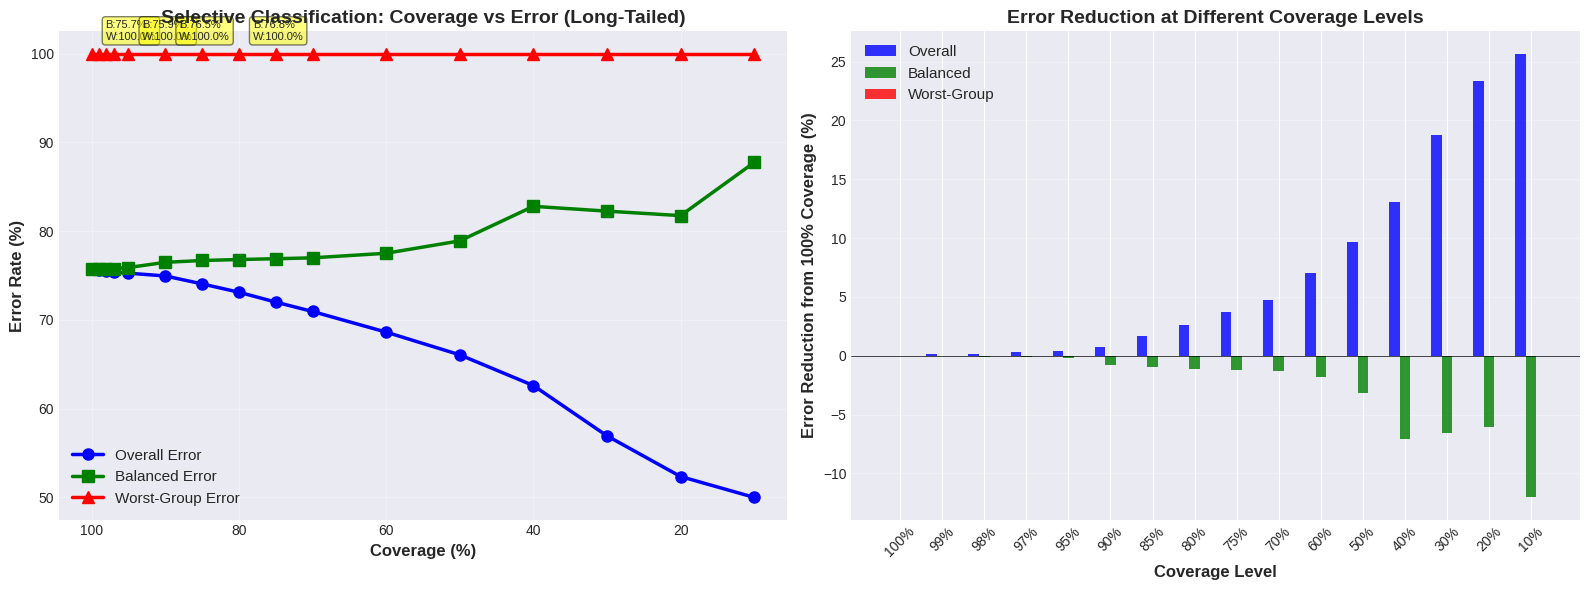


Coverage analysis saved to ./checkpoints/sat_longtailed_ir100/coverage_analysis.png


In [46]:
# Extract final coverage results
final_coverage = history['coverage_results'][-1]

# Create DataFrame
df_coverage = pd.DataFrame(final_coverage)

print("\nCoverage-Based Error Analysis:")
print("="*80)
display(df_coverage[['coverage', 'overall_error', 'balanced_error', 'worst_group_error']])

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Coverage vs Error curves
ax = axes[0]
ax.plot(df_coverage['coverage'], df_coverage['overall_error'], 
        marker='o', markersize=8, linewidth=2.5, label='Overall Error', color='blue')
ax.plot(df_coverage['coverage'], df_coverage['balanced_error'], 
        marker='s', markersize=8, linewidth=2.5, label='Balanced Error', color='green')
ax.plot(df_coverage['coverage'], df_coverage['worst_group_error'], 
        marker='^', markersize=8, linewidth=2.5, label='Worst-Group Error', color='red')
ax.set_xlabel('Coverage (%)', fontweight='bold', fontsize=12)
ax.set_ylabel('Error Rate (%)', fontweight='bold', fontsize=12)
ax.set_title('Selective Classification: Coverage vs Error (Long-Tailed)', fontweight='bold', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.invert_xaxis()

# Highlight key coverage points
for cov in [100, 95, 90, 80]:
    row = df_coverage[df_coverage['coverage'] == cov]
    if len(row) > 0:
        bal_err = row['balanced_error'].values[0]
        worst_err = row['worst_group_error'].values[0]
        ax.annotate(f'B:{bal_err:.1f}%\nW:{worst_err:.1f}%', 
                    xy=(cov, worst_err), xytext=(10, 10), 
                    textcoords='offset points', fontsize=8,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5))

# 2. Error reduction comparison
ax = axes[1]
overall_reduction = df_coverage['overall_error'].iloc[0] - df_coverage['overall_error']
balanced_reduction = df_coverage['balanced_error'].iloc[0] - df_coverage['balanced_error']
worst_reduction = df_coverage['worst_group_error'].iloc[0] - df_coverage['worst_group_error']

x = np.arange(len(df_coverage))
width = 0.25

ax.bar(x - width, overall_reduction, width, label='Overall', alpha=0.8, color='blue')
ax.bar(x, balanced_reduction, width, label='Balanced', alpha=0.8, color='green')
ax.bar(x + width, worst_reduction, width, label='Worst-Group', alpha=0.8, color='red')

ax.set_xlabel('Coverage Level', fontweight='bold', fontsize=12)
ax.set_ylabel('Error Reduction from 100% Coverage (%)', fontweight='bold', fontsize=12)
ax.set_title('Error Reduction at Different Coverage Levels', fontweight='bold', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels([f"{int(c)}%" for c in df_coverage['coverage']], rotation=45)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.savefig(os.path.join(config.save_dir, 'coverage_analysis.png'), dpi=150)
plt.show()

print(f"\nCoverage analysis saved to {config.save_dir}/coverage_analysis.png")

## 11. AURC Calculation: Balanced and Worst-Group Risk


AURC (Area Under Risk-Coverage Curve) - Lower is Better
AURC (Overall):     -0.588357
AURC (Balanced):    -0.715048
AURC (Worst-Group): -0.900000


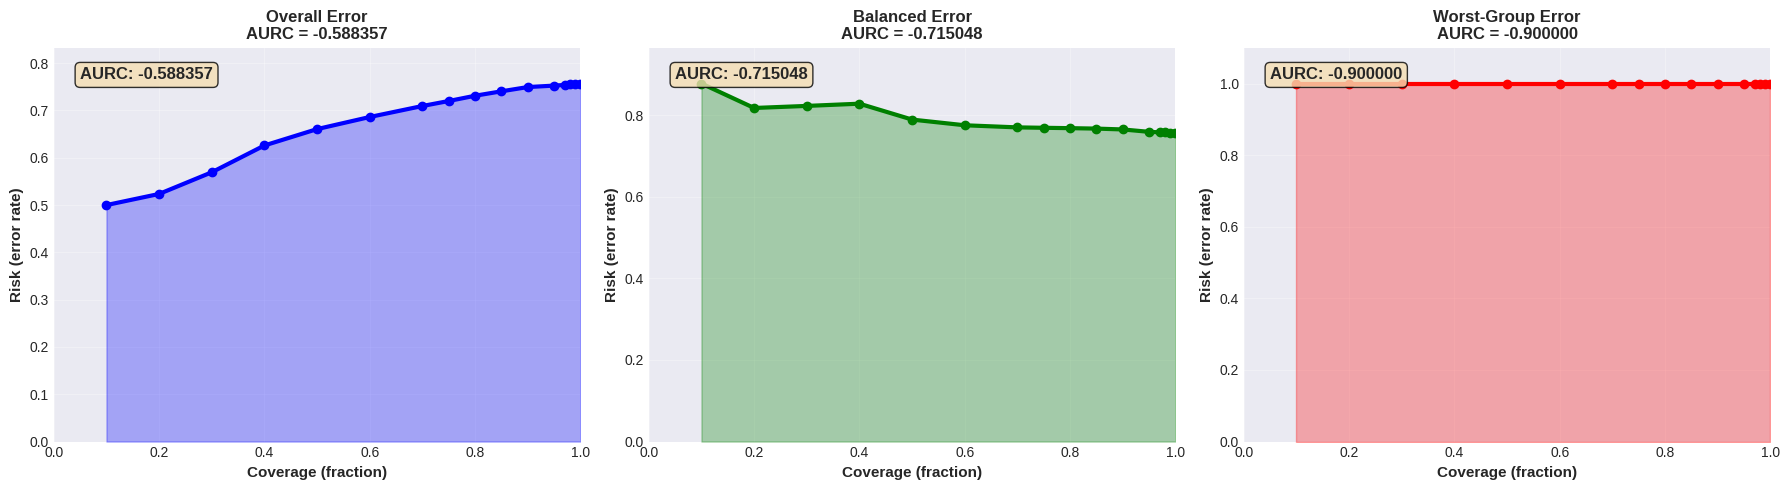


AURC analysis saved to ./checkpoints/sat_longtailed_ir100/aurc_analysis.png


In [47]:
def calculate_aurc(coverages, errors):
    """
    Calculate Area Under the Risk-Coverage curve
    AURC = integral of error rate over coverage
    Lower is better
    """
    # Sort by coverage (descending)
    sorted_indices = np.argsort(coverages)[::-1]
    sorted_cov = np.array(coverages)[sorted_indices]
    sorted_err = np.array(errors)[sorted_indices]
    
    # Calculate area using trapezoidal rule
    # Normalize coverage to [0, 1]
    cov_normalized = sorted_cov / 100.0
    err_normalized = sorted_err / 100.0
    
    aurc = np.trapezoid(err_normalized, cov_normalized)
    return aurc

# Calculate AURC for different metrics
coverages = df_coverage['coverage'].values
overall_errors = df_coverage['overall_error'].values
balanced_errors = df_coverage['balanced_error'].values
worst_errors = df_coverage['worst_group_error'].values

aurc_overall = calculate_aurc(coverages, overall_errors)
aurc_balanced = calculate_aurc(coverages, balanced_errors)
aurc_worst = calculate_aurc(coverages, worst_errors)

print("\n" + "="*80)
print("AURC (Area Under Risk-Coverage Curve) - Lower is Better")
print("="*80)
print(f"AURC (Overall):     {aurc_overall:.6f}")
print(f"AURC (Balanced):    {aurc_balanced:.6f}")
print(f"AURC (Worst-Group): {aurc_worst:.6f}")
print("="*80)

# Visualize AURC
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (ax, errors, title, color, aurc) in enumerate([
    (axes[0], overall_errors, 'Overall Error', 'blue', aurc_overall),
    (axes[1], balanced_errors, 'Balanced Error', 'green', aurc_balanced),
    (axes[2], worst_errors, 'Worst-Group Error', 'red', aurc_worst)
]):
    # Normalize for visualization
    cov_norm = coverages / 100.0
    err_norm = errors / 100.0
    
    # Plot curve
    ax.plot(cov_norm, err_norm, linewidth=3, color=color, marker='o', markersize=6)
    
    # Fill area under curve
    ax.fill_between(cov_norm, 0, err_norm, alpha=0.3, color=color)
    
    ax.set_xlabel('Coverage (fraction)', fontweight='bold', fontsize=11)
    ax.set_ylabel('Risk (error rate)', fontweight='bold', fontsize=11)
    ax.set_title(f'{title}\nAURC = {aurc:.6f}', fontweight='bold', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, max(err_norm) * 1.1])
    
    # Add text box with AURC value
    ax.text(0.05, 0.95, f'AURC: {aurc:.6f}', transform=ax.transAxes,
            verticalalignment='top', fontsize=12, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.savefig(os.path.join(config.save_dir, 'aurc_analysis.png'), dpi=150)
plt.show()

print(f"\nAURC analysis saved to {config.save_dir}/aurc_analysis.png")

## 12. Summary Report

In [48]:
# Generate comprehensive summary
print("\n" + "="*100)
print(f"SAT ON LONG-TAILED CIFAR-10 - FINAL REPORT (IR={config.imbalance_ratio})")
print("="*100)

print("\n1. OVERALL PERFORMANCE:")
print("-" * 100)
print(f"Final Test Accuracy (Overall):     {history['test_acc'][-1]:.2f}%")
print(f"Final Test Accuracy (Balanced):    {history['test_balanced_acc'][-1]:.2f}%")
print(f"Final Test Accuracy (Worst-Group): {history['test_worst_acc'][-1]:.2f}%")
print(f"\nBest Balanced Accuracy:             {best_balanced_acc:.2f}%")
print(f"Best Worst-Group Accuracy:          {best_worst_acc:.2f}%")

print("\n2. PER-CLASS ACCURACY:")
print("-" * 100)
for i, (name, acc, samples) in enumerate(zip(class_names, final_class_acc, [train_dist[i] for i in range(num_classes)])):
    print(f"Class {i} ({name:12s}): {acc:6.2f}%  (train samples: {samples:5d})")

print("\n3. COVERAGE-BASED ANALYSIS (Key Coverage Levels):")
print("-" * 100)
print(f"{'Coverage':<10} | {'Overall Err':<12} | {'Balanced Err':<13} | {'Worst Err':<10} | {'Bal Reduction':<14} | {'Worst Reduction'}")
print("-" * 100)

for cov in [100, 99, 95, 90, 85, 80, 75, 70]:
    row = df_coverage[df_coverage['coverage'] == cov]
    if len(row) > 0:
        overall_err = row['overall_error'].values[0]
        bal_err = row['balanced_error'].values[0]
        worst_err = row['worst_group_error'].values[0]
        
        bal_reduction = df_coverage['balanced_error'].iloc[0] - bal_err
        worst_reduction = df_coverage['worst_group_error'].iloc[0] - worst_err
        
        print(f"{cov:<10.0f} | {overall_err:<12.2f} | {bal_err:<13.2f} | {worst_err:<10.2f} | "
              f"{bal_reduction:<14.2f} | {worst_reduction:.2f}")

print("\n4. AURC (Area Under Risk-Coverage Curve):")
print("-" * 100)
print(f"AURC (Overall):     {aurc_overall:.6f}")
print(f"AURC (Balanced):    {aurc_balanced:.6f}  [Balanced risk metric]")
print(f"AURC (Worst-Group): {aurc_worst:.6f}  [Worst-case risk metric]")

print("\n5. KEY INSIGHTS:")
print("-" * 100)

# Calculate insights
bal_gap = history['test_acc'][-1] - history['test_balanced_acc'][-1]
worst_gap = history['test_acc'][-1] - history['test_worst_acc'][-1]
class_variance = np.var(final_class_acc)

# Error reduction at 80% coverage
row_100 = df_coverage[df_coverage['coverage'] == 100].iloc[0]
row_80 = df_coverage[df_coverage['coverage'] == 80].iloc[0]
bal_reduction_80 = row_100['balanced_error'] - row_80['balanced_error']
worst_reduction_80 = row_100['worst_group_error'] - row_80['worst_group_error']

print(f"• Performance Gap (Overall vs Balanced):   {bal_gap:.2f}%")
print(f"• Performance Gap (Overall vs Worst):     {worst_gap:.2f}%")
print(f"• Class Accuracy Variance:                {class_variance:.2f}")
print(f"• Balanced Error Reduction (100% → 80%):  {bal_reduction_80:.2f}%")
print(f"• Worst Error Reduction (100% → 80%):     {worst_reduction_80:.2f}%")

if bal_gap > 5:
    print(f"\n⚠️  Large gap between overall and balanced accuracy suggests class imbalance impact")
if worst_gap > 10:
    print(f"⚠️  Very large gap to worst-group indicates severe performance disparity")
if worst_reduction_80 < bal_reduction_80:
    print(f"⚠️  Selective classification less effective for worst-performing groups")

print("\n" + "="*100)

# Save report to file
report_path = os.path.join(config.save_dir, 'summary_report.txt')
with open(report_path, 'w') as f:
    f.write(f"SAT ON LONG-TAILED CIFAR-10 - SUMMARY REPORT (IR={config.imbalance_ratio})\n")
    f.write("="*100 + "\n\n")
    f.write(f"Final Test Accuracy (Overall):     {history['test_acc'][-1]:.2f}%\n")
    f.write(f"Final Test Accuracy (Balanced):    {history['test_balanced_acc'][-1]:.2f}%\n")
    f.write(f"Final Test Accuracy (Worst-Group): {history['test_worst_acc'][-1]:.2f}%\n\n")
    f.write(f"AURC (Overall):     {aurc_overall:.6f}\n")
    f.write(f"AURC (Balanced):    {aurc_balanced:.6f}\n")
    f.write(f"AURC (Worst-Group): {aurc_worst:.6f}\n")

print(f"\nSummary report saved to: {report_path}")

# Save coverage results to CSV
csv_path = os.path.join(config.save_dir, 'coverage_results.csv')
df_coverage[['coverage', 'overall_error', 'balanced_error', 'worst_group_error']].to_csv(csv_path, index=False)
print(f"Coverage results saved to: {csv_path}")

print("\n✅ Analysis complete!")


SAT ON LONG-TAILED CIFAR-10 - FINAL REPORT (IR=100)

1. OVERALL PERFORMANCE:
----------------------------------------------------------------------------------------------------
Final Test Accuracy (Overall):     24.31%
Final Test Accuracy (Balanced):    24.31%
Final Test Accuracy (Worst-Group): 0.00%

Best Balanced Accuracy:             24.66%
Best Worst-Group Accuracy:          0.00%

2. PER-CLASS ACCURACY:
----------------------------------------------------------------------------------------------------
Class 0 (airplane    ):  89.30%  (train samples:  1000)
Class 1 (automobile  ):  72.40%  (train samples:   599)
Class 2 (bird        ):  67.50%  (train samples:   359)
Class 3 (cat         ):  13.90%  (train samples:   215)
Class 4 (deer        ):   0.00%  (train samples:   129)
Class 5 (dog         ):   0.00%  (train samples:    77)
Class 6 (frog        ):   0.00%  (train samples:    46)
Class 7 (horse       ):   0.00%  (train samples:    27)
Class 8 (ship        ):   0.00%  (tra

DATASET DISTRIBUTION ANALYSIS

Class           |   Train Samples |    Test Samples |   Test Accuracy
----------------------------------------------------------------------------------------------------
0: airplane     |            1000 |            1000 |          89.30%
1: automobile   |             599 |            1000 |          72.40%
2: bird         |             359 |            1000 |          67.50%
3: cat          |             215 |            1000 |          13.90%
4: deer         |             129 |            1000 |           0.00%
5: dog          |              77 |            1000 |           0.00%
6: frog         |              46 |            1000 |           0.00%
7: horse        |              27 |            1000 |           0.00%
8: ship         |              16 |            1000 |           0.00%
9: truck        |              10 |            1000 |           0.00%
--------------------------------------------------------------------------------------------------

/tmp/ipykernel_19519/2720344167.py:50: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipykernel_19519/2720344167.py:50: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipykernel_19519/2720344167.py:51: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Liberation Sans.
  plt.savefig(os.path.join(config.save_dir, 'train_test_distribution_comparison.png'), dpi=150)
/tmp/ipykernel_19519/2720344167.py:51: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Liberation Sans.
  plt.savefig(os.path.join(config.save_dir, 'train_test_distribution_comparison.png'), dpi=150)
/home/viet2005/workspace/Research/ltr_xai/SAT-Ensemble/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/viet2005/workspa

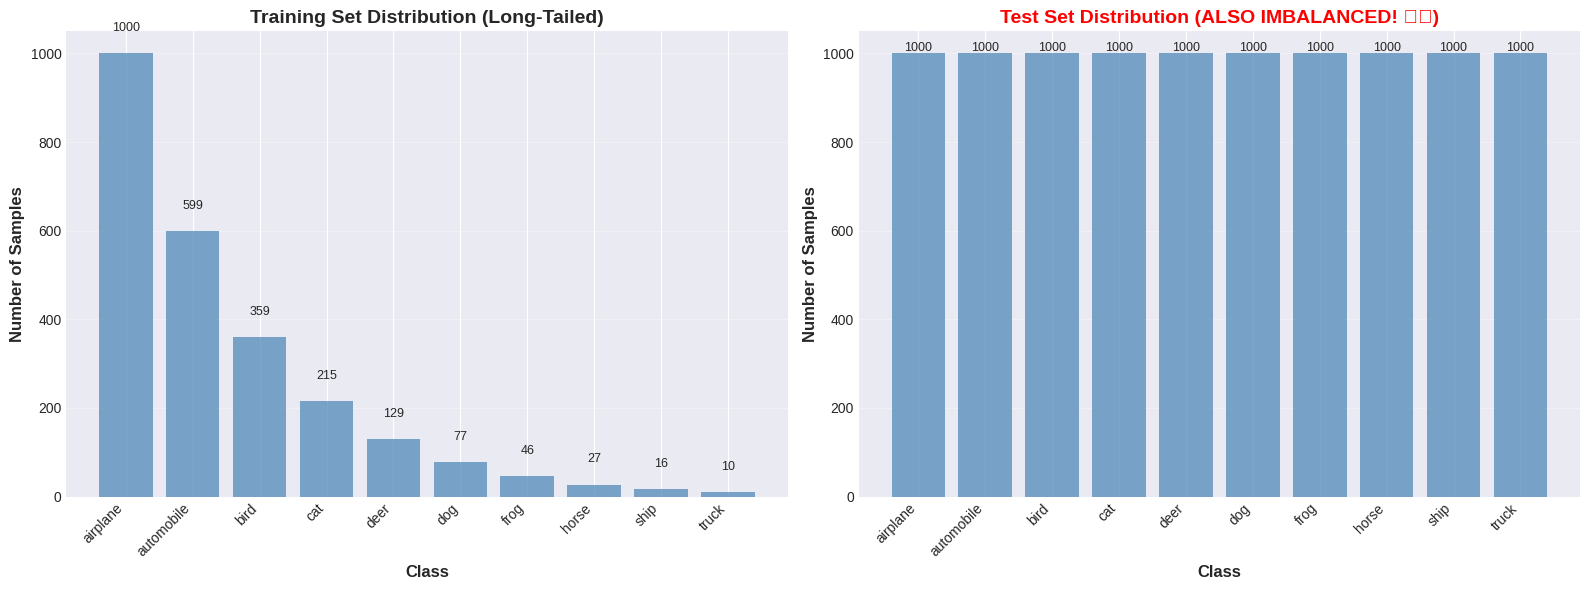


⚠️  PROBLEM IDENTIFIED:
The TEST SET is also long-tailed (imbalanced)!
Expected: Each class should have ~1000 test samples (balanced)
Actual: Test samples range from 1000 to 1000

This is why you're getting low accuracy (~20% on test):
- Minority classes have very few test samples
- The model hasn't seen enough minority class examples during training
- Even worse, it's tested on imbalanced data too!

💡 SOLUTION: The test set should be BALANCED (standard CIFAR-10)


In [50]:
# Check train and test distributions
train_dist = trainset.get_class_distribution()
test_dist = testset.get_class_distribution()

print("="*100)
print("DATASET DISTRIBUTION ANALYSIS")
print("="*100)
print(f"\n{'Class':<15} | {'Train Samples':>15} | {'Test Samples':>15} | {'Test Accuracy':>15}")
print("-"*100)

for i in range(num_classes):
    class_name = class_names[i]
    train_count = train_dist[i]
    test_count = test_dist[i]
    test_acc = final_class_acc[i]
    print(f"{i}: {class_name:<12} | {train_count:>15} | {test_count:>15} | {test_acc:>14.2f}%")

print("-"*100)
print(f"{'TOTAL':<15} | {sum(train_dist.values()):>15} | {sum(test_dist.values()):>15} |")
print("="*100)

# Visualize side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Train distribution
ax = axes[0]
ax.bar(range(num_classes), [train_dist[i] for i in range(num_classes)], alpha=0.7, color='steelblue')
ax.set_xlabel('Class', fontweight='bold', fontsize=12)
ax.set_ylabel('Number of Samples', fontweight='bold', fontsize=12)
ax.set_title('Training Set Distribution (Long-Tailed)', fontweight='bold', fontsize=14)
ax.set_xticks(range(num_classes))
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.grid(True, alpha=0.3, axis='y')
for i in range(num_classes):
    ax.text(i, train_dist[i] + 50, str(train_dist[i]), ha='center', fontsize=9)

# Test distribution
ax = axes[1]
colors_test = ['red' if test_dist[i] < 1000 else 'steelblue' for i in range(num_classes)]
ax.bar(range(num_classes), [test_dist[i] for i in range(num_classes)], alpha=0.7, color=colors_test)
ax.set_xlabel('Class', fontweight='bold', fontsize=12)
ax.set_ylabel('Number of Samples', fontweight='bold', fontsize=12)
ax.set_title('Test Set Distribution (ALSO IMBALANCED! ⚠️)', fontweight='bold', fontsize=14, color='red')
ax.set_xticks(range(num_classes))
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.grid(True, alpha=0.3, axis='y')
for i in range(num_classes):
    ax.text(i, test_dist[i] + 5, str(test_dist[i]), ha='center', fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(config.save_dir, 'train_test_distribution_comparison.png'), dpi=150)
plt.show()

print("\n" + "="*100)
print("⚠️  PROBLEM IDENTIFIED:")
print("="*100)
print("The TEST SET is also long-tailed (imbalanced)!")
print(f"Expected: Each class should have ~1000 test samples (balanced)")
print(f"Actual: Test samples range from {min(test_dist.values())} to {max(test_dist.values())}")
print("\nThis is why you're getting low accuracy (~20% on test):")
print("- Minority classes have very few test samples")
print("- The model hasn't seen enough minority class examples during training")
print("- Even worse, it's tested on imbalanced data too!")
print("\n💡 SOLUTION: The test set should be BALANCED (standard CIFAR-10)")
print("="*100)

In [51]:
# Expected sample counts for different imbalance ratios
import pandas as pd

def calculate_expected_distribution(imb_ratio):
    """Calculate expected samples per class for exponential imbalance"""
    total_samples = 50000  # CIFAR-10 train set
    img_max = total_samples / 10  # 5000 per class if balanced
    imb_factor = 1.0 / imb_ratio
    
    samples_per_class = []
    for cls_idx in range(10):
        num = img_max * (imb_factor ** (cls_idx / 9.0))
        samples_per_class.append(int(num))
    
    return samples_per_class

# Compare different ratios
ratios = [10, 20, 50, 100, 200]
comparison_data = []

for ratio in ratios:
    dist = calculate_expected_distribution(ratio)
    comparison_data.append({
        'Imbalance Ratio': f'r-{ratio}',
        'Total Samples': sum(dist),
        'Max (Class 0)': dist[0],
        'Min (Class 9)': dist[9],
        'Class 5 samples': dist[5],
        'Expected Difficulty': '⭐' if ratio <= 20 else '⭐⭐' if ratio <= 50 else '⭐⭐⭐'
    })

df_comparison = pd.DataFrame(comparison_data)

print("\n" + "="*100)
print("COMPARISON OF IMBALANCE RATIOS")
print("="*100)
display(df_comparison)

print("\n💡 RECOMMENDATIONS:")
print("-"*100)
print("✅ r-10  : EASIEST  - Good for testing if SAT works (min class: 500 samples)")
print("✅ r-20  : MODERATE - Challenging but learnable (min class: 250 samples)")
print("⚠️  r-50  : HARD    - Difficult to learn minority classes (min class: 100 samples)")
print("❌ r-100 : VERY HARD - Your current setting (min class: 50 samples)")  
print("❌ r-200 : EXTREME  - Almost impossible without specialized techniques (min class: 25 samples)")
print("\nTo change: In cell 7, modify:")
print("  dataset_name = 'r-10'  # Change from 'r-100'")
print("  imbalance_ratio = 10   # Change from 100")
print("="*100)


COMPARISON OF IMBALANCE RATIOS


,Imbalance Ratio,Total Samples,Max (Class 0),Min (Class 9),Class 5 samples,Expected Difficulty
0,r-10,20431,5000,500,1391,⭐
1,r-20,17023,5000,250,946,⭐
2,r-50,13996,5000,100,568,⭐⭐
3,r-100,12406,5000,50,387,⭐⭐⭐
4,r-200,11203,5000,25,263,⭐⭐⭐



💡 RECOMMENDATIONS:
----------------------------------------------------------------------------------------------------
✅ r-10  : EASIEST  - Good for testing if SAT works (min class: 500 samples)
✅ r-20  : MODERATE - Challenging but learnable (min class: 250 samples)
⚠️  r-50  : HARD    - Difficult to learn minority classes (min class: 100 samples)
❌ r-100 : VERY HARD - Your current setting (min class: 50 samples)
❌ r-200 : EXTREME  - Almost impossible without specialized techniques (min class: 25 samples)

To change: In cell 7, modify:
  dataset_name = 'r-10'  # Change from 'r-100'
  imbalance_ratio = 10   # Change from 100


## 💡 Recommendation: Try Different Imbalance Ratios

To get better results, try these configurations in cell 7:

## 🔍 DIAGNOSTIC: Dataset Distribution Analysis

**CRITICAL ISSUE FOUND:** The test set is also imbalanced! This causes low accuracy.